## Project: Sentiment Analysis for Social Media Data
### By: Arsalan, Akash and Aashi

In [386]:
from pprint import pprint
import pandas as pd
import numpy as np
import praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sa 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [387]:
#defining the praw reddit tool
user_agent = "Data 1.0"
reddit = praw.Reddit(
    client_id="eMB6WKPL5okjyK0HEp-jLA",
    client_secret="nI8rPm-U8OVJGbhxx5EplOsZlAEsiA",
    user_agent=user_agent
)

Accessing data from  subreddits named : "Worldnews", "sadp', "Dreams" and "happy".

In [388]:

titles = set() #to restrict repetition of titles

def extract_remaining_rate_limit(response_headers):  #for esuring there is no problem with extracting titles
    try:
        #extract remaining rate limit value from response headers
        remaining_rate_limit = float(response_headers.get("x-ratelimit-remaining", "0").split(',')[0])
        return remaining_rate_limit
    except ValueError:
        return 0  # Return 0 if there's an issue with the rate limit header

#extracting titles from the subreddits
for submission in reddit.subreddit('worldnews').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)
    
for submission in reddit.subreddit('sad').new(limit=None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)
   
for submission in reddit.subreddit('Dreams').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)

for submission in reddit.subreddit('happy').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)
   
print(f"Amount of lines generated: {len(titles)}")

Amount of lines generated: 3323


Converting this data extracted to a dataframe

In [389]:
data = pd.DataFrame(titles)
data.head()
data.to_csv("data.csv", header=False, encoding='utf-8', index= False ) #converting it to a csv

Using vader_lexicon for sentiment analysing

In [390]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [391]:
sia = sa() #creating an analyser
sentimented_sentences = []

#doing a sentiment classification on the data extracted
for i in titles:
    score = sia.polarity_scores(i) #making a dictionary
    score['Post'] = i
    sentimented_sentences.append(score)

pprint(sentimented_sentences[:3], width = 150)

[{'Post': "For the first time in weeks I'm excited for the future", 'compound': 0.34, 'neg': 0.0, 'neu': 0.806, 'pos': 0.194},
 {'Post': 'French court orders return of deported Uzbek national in rebuke to interior minister',
  'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'Post': 'Thousands of tons of dead sardines wash ashore in northern Japan', 'compound': -0.6486, 'neg': 0.301, 'neu': 0.699, 'pos': 0.0}]


In [392]:
df_sentimented = pd.DataFrame.from_records(sentimented_sentences) #making a new dataframe of the sentiment analysed dictionary

display(df_sentimented.head())

,neg,neu,pos,compound,Post
0,0.000,0.806,0.194,0.3400,For the first time in weeks I'm excited for th...
1,0.000,1.000,0.000,0.0000,French court orders return of deported Uzbek n...
2,0.301,0.699,0.000,-0.6486,Thousands of tons of dead sardines wash ashore...
3,0.439,0.561,0.000,-0.6908,What's the fastest way to kill yourself?
4,0.000,0.600,0.400,0.2500,Hair shaving in dream


Giving the data in the dataframe a sentiment value: 1 for positive, -1 for negative and 0 for neutral

In [393]:
df_sentimented["Sen Label"] = 0
df_sentimented.loc[df_sentimented['compound'] > 0.2, "Sen Label"] = 1  
df_sentimented.loc[df_sentimented['compound'] <  -0.2, "Sen Label"] = -1 
df_sentimented.head()

,neg,neu,pos,compound,Post,Sen Label
0,0.000,0.806,0.194,0.3400,For the first time in weeks I'm excited for th...,1
1,0.000,1.000,0.000,0.0000,French court orders return of deported Uzbek n...,0
2,0.301,0.699,0.000,-0.6486,Thousands of tons of dead sardines wash ashore...,-1
3,0.439,0.561,0.000,-0.6908,What's the fastest way to kill yourself?,-1
4,0.000,0.600,0.400,0.2500,Hair shaving in dream,1


In [394]:
df_sentimented_updated = df_sentimented[["Post", "Sen Label"]]
df_sentimented_updated.to_csv("data_sen.csv", encoding='utf-8', index=False)
df_sentimented_updated.head()

,Post,Sen Label
0,For the first time in weeks I'm excited for th...,1
1,French court orders return of deported Uzbek n...,0
2,Thousands of tons of dead sardines wash ashore...,-1
3,What's the fastest way to kill yourself?,-1
4,Hair shaving in dream,1


### PREPROCESSING

In [395]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [396]:
# * WE DID TRY CHANGING SLANG BUT IT WAS HAVING AN EFFECT ON THE OUTPUT * #

# slang_df = pd.read_csv("urbandict-word-defs.csv", on_bad_lines='skip')
# # Create a dictionary from the dataframe
# slang_dict = pd.Series(slang_df.definition.values, index=slang_df.word).to_dict()

# def r_slang(text, slang_dict):
#     # Tokenize the text
#     tokens = word_tokenize(text)
#     replaced_tokens = []
#     for word in tokens:
#         if word in slang_dict:
#             replaced_tokens.append(slang_dict[word]) # If the word is slang, replace it with its definition
#         else:
#             replaced_tokens.append(word)
#     return ' '.join(replaced_tokens)

def r_urls(text): #removing urls function
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def r_html(text): #remving html function
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Emoji expression code
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           "]+", flags=re.UNICODE)


def r_hashtags(text): #removing hashtags function
    return re.sub(r'#\w+', '', text)

def r_emojis(text): #removing emojis function
    return emoji_pattern.sub(r'', text)

#This function is for removing: URLs,HTML tags,hashtags,emojis from the text
def preprocess_text(text):
    text = text.lower()  
    #text = r_slang(text, slang_dict) 
    text = r_urls(text)  # Remove 
    text = r_html(text)  # Remove 
    text = r_hashtags(text)  # Remove 
    text = r_emojis(text)  # Remove 
    tokens = word_tokenize(text)     # Tokenization

    # Remove stopwords and non-alphanumeric characters
    clean_tokens = []
    for word in tokens:
        if word.isalnum() and word not in stop_words:
            clean_tokens.append(word)

    # Lemmatization
    lemmatized_tokens = []
    for word in clean_tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_tokens.append(lemmatized_word)

    return ' '.join(lemmatized_tokens)

In [397]:
#preprocessing the actual data
df_sentimented_process = df_sentimented[["Post", "Sen Label"]].copy()

df_sentimented_updated['Processed_Post'] = df_sentimented_process['Post'].apply(preprocess_text)

display(df_sentimented_updated.head())

# Optionally, save to CSV
df_sentimented_updated.to_csv("processed_data.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_14544\3964557773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimented_updated['Processed_Post'] = df_sentimented_process['Post'].apply(preprocess_text)


,Post,Sen Label,Processed_Post
0,For the first time in weeks I'm excited for th...,1,first time week excited future
1,French court orders return of deported Uzbek n...,0,french court order return deported uzbek natio...
2,Thousands of tons of dead sardines wash ashore...,-1,thousand ton dead sardine wash ashore northern...
3,What's the fastest way to kill yourself?,-1,fastest way kill
4,Hair shaving in dream,1,hair shaving dream


### FEATURE EXTRACTION

In [398]:
processed_posts = df_sentimented_updated['Processed_Post']

# Create a Bag-of-Words vectorizer
vectorizer = CountVectorizer()

# Fit and transform your preprocessed posts
bow_features = vectorizer.fit_transform(processed_posts)
word_freq = np.sum(bow_features.toarray(), axis=0)
#making a dataframe for unique words and their frequency and give the top 10
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'freq': word_freq}).nlargest(10, 'freq')

word_freq_df.head(10)


,word,freq
1529,dream,596
2219,happy,249
5241,year,205
1289,day,137
2782,life,121
1974,friend,116
2792,like,111
4766,today,107
1842,feel,106
1887,first,105


In [399]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform your preprocessed posts
tfidf_features = tfidf_vectorizer.fit_transform(processed_posts)
# tfidf_features is now a sparse matrix containing TF-IDF features for your dataset

tfidf_means = np.mean(tfidf_features.toarray(), axis=0)
#making a dataframe for unique words and their frequency and give the top 10
tfidf_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), 'tfidf': tfidf_means}).nlargest(10, 'tfidf')
tfidf_df.head(10)

,word,tfidf
1529,dream,0.045133
2219,happy,0.015741
5241,year,0.013571
2782,life,0.011138
1974,friend,0.010179
1289,day,0.009598
5137,weird,0.009210
1842,feel,0.008873
2275,help,0.008767
2792,like,0.008497


In [400]:
# Load pre-trained Word2Vec embeddings
word2vec_model = api.load("glove-twitter-25")

# Function to vectorize a sentence into an embedding
def document_vector(doc):
    words_in_doc = doc.split()
    valid_words = []
    for word in words_in_doc:
        if word in word2vec_model.key_to_index:  # Checking if the word is in the model's vocabulary
            valid_words.append(word)  # If the word is valid append it

    # Check if there are valid words in the document and return their vector mean
    if valid_words:
        return np.mean(word2vec_model[valid_words], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Applying the function over here
word2vec_features = df_sentimented_updated['Processed_Post'].apply(document_vector)
word2vec_f = np.array([document_vector(post) for post in processed_posts])
cosine_sim_word2vec = cosine_similarity(word2vec_f)
print("Cosine Similarity (Word2Vec):")
pprint(cosine_sim_word2vec)

word2vec_features.to_csv("processed_featuredata.csv", index=False)

Cosine Similarity (Word2Vec):
array([[1.        , 0.72403318, 0.76821133, ..., 0.92300521, 0.79844115,
        0.92294876],
       [0.72403318, 1.        , 0.81670066, ..., 0.69273225, 0.59552982,
        0.74945196],
       [0.76821133, 0.81670066, 1.        , ..., 0.8196249 , 0.76671805,
        0.79123753],
       ...,
       [0.92300521, 0.69273225, 0.8196249 , ..., 1.        , 0.90882197,
        0.94945542],
       [0.79844115, 0.59552982, 0.76671805, ..., 0.90882197, 1.        ,
        0.86922563],
       [0.92294876, 0.74945196, 0.79123753, ..., 0.94945542, 0.86922563,
        1.        ]])


### MODEL SELECTION AND TRAINING

In [401]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df_sentimented_updated['Sen Label'], test_size=0.2, random_state=50)


In [402]:
# Initialize the SVM model
svm_model = SVC()

# Train the model with the training data
svm_model.fit(X_train, y_train)


SVC()

In [403]:
#Make predictions on the training set and test set
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

#Evaluate the performance
print("Training Performance:")
print(classification_report(y_train, y_train_pred))

print("Testing Performance:")
print(classification_report(y_test, y_test_pred))


Training Performance:
              precision    recall  f1-score   support

          -1       0.99      0.98      0.99       653
           0       0.99      0.98      0.98       900
           1       0.98      1.00      0.99      1105

    accuracy                           0.99      2658
   macro avg       0.99      0.98      0.99      2658
weighted avg       0.99      0.99      0.99      2658

Testing Performance:
              precision    recall  f1-score   support

          -1       0.88      0.38      0.53       157
           0       0.59      0.84      0.70       238
           1       0.80      0.77      0.78       270

    accuracy                           0.70       665
   macro avg       0.76      0.66      0.67       665
weighted avg       0.75      0.70      0.69       665



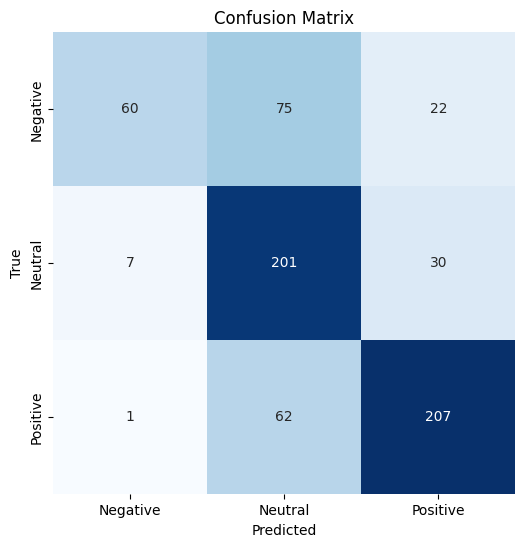

In [404]:
classes = ['Negative', 'Neutral', 'Positive']
confusion = confusion_matrix(y_test, y_test_pred)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [405]:
import joblib
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']